# Microwave acid digestion run analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# options: inline or widget
%matplotlib widget

In [3]:
import warnings

signal_settings = {
    'window_length': 11,
    'plateau_threshold': 0.1,
    'plateau_size':10,
    'inflection_threshold': 0.02,
    'peak_height': 10
}

class MADRun(object):
    def __init__(self, filename, sample_info=None, runs_info=None):
        """
        Represents a microwave digestion run, allowing to visualize and analyze the
        profiles for the different samples.

        Args:
          filename (str): Path to file.
          sample_info (pd.Series): Data series with metadata for the run and different samples.
          runs_info (pd.DataFrame): Data frame with metadata for multiple runs, containing the
            present filename run. Based on the run name in the filename, the information will be
            retrieved from this data frame based on the index.
        """
        self.read_multiwave_csv(filename)
        self.process_multiwave_metadata()
        if sample_info is not None:
            self.sample_info = sample_info
        elif runs_info is not None:
            try: self.sample_info = runs_info.loc[self.metadata['Run Name']]
            except KeyError:
                self.sample_info = None
                warnings.warn(f"No run info for {self.metadata['Run Name']}")

    def __repr__(self):
        return f"<MADRun {self.metadata['Run Name']}>"
        
    def read_multiwave_csv(self, filename):
        from datetime import datetime, timedelta
        with open(filename, encoding = "utf-16le") as multiwave_file:
            self.metadata = []
            for line in multiwave_file:
                self.metadata.append(line)
                if line.startswith('Result Data'):
                    break
            self.data = pd.read_csv(multiwave_file, sep='\t')
            self.data["Time"] = self.data["Time"].apply(
                lambda x: datetime.strptime(x, '%H:%M:%S')#.time()
            ).apply(lambda t: timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds())
        return self.data

    def process_multiwave_metadata(self):
        self.metadata = [tuple(l.strip().split('\t')) for l in self.metadata]
        try:
            self.warnings = self.metadata[self.metadata.index(('Warnings',))+1:-2]
            self.metadata = self.metadata[:self.metadata.index(('Warnings',))-1]
        except ValueError:
            self.warnings = None
            self.metadata = self.metadata[:-3]
        self.metadata = pd.Series({l[0]:l[1] if len(l)==2 else l[1:] for l in self.metadata if l[0]})
        self.vessels = int(self.metadata['Number of Vessels'])
        if self.vessels == 1:
            self.vessel_indices = (1,)
            self.plot_config = {'nrows':1, 'ncols':1}
        elif self.vessels == 3:
            self.vessel_indices = (3,7,11)
            self.plot_config = {'nrows':1, 'ncols':3}
        elif self.vessels == 4:
            self.vessel_indices = (1,4,7,10)
            self.plot_config = {'nrows':2, 'ncols':2}
        elif self.vessels == 6:
            self.vessel_indices = (1,3,5,7,9,11)
            self.plot_config = {'nrows':2, 'ncols':3}
        elif self.vessels == 8:
            self.vessel_indices = (2,3,5,6,8,9,11,12)
            self.plot_config = {'nrows':4, 'ncols':2}
        elif self.vessels == 12:
            self.vessel_indices = range(1,13)
            self.plot_config = {'nrows':4, 'ncols':3}
        else:
            raise NotImplementedError
        
    def plot(self):
        return self.data[[
            "Time"]+[f"T Pos. {i}" for i in self.vessel_indices]+["Power"
        ]].ffill().set_index("Time").plot.line()
        # optional: .infer_objects(copy=False).interpolate() instead of .ffill()

    def identify_profile_features(self, sample, signal_settings=signal_settings, ax=None, legend=True):
        sample_data = pd.DataFrame({'raw':self.data.set_index('Time')[sample].dropna()})
        sample_data = sample_data.reset_index().drop_duplicates(['Time']).set_index('Time')
        sample_profile = MADProfile(
            sample_data, ax=ax, legend=legend, **signal_settings
        )
            
        return sample_profile

    def profile_feature_analysis(
        self, signal_settings=signal_settings, 
        include_sample_weight=True, include_sample_metadata=None, include_metadata=None
    ):
        samples = [f"T Pos. {i}" for i in self.vessel_indices]
        self.profiles = {}
        self.features = {}
        fig, axes = plt.subplots(
            nrows=self.plot_config['nrows'], ncols=self.plot_config['ncols'], sharex=True
        )
        for s, ax in zip(samples,axes.flatten()):
            ax.set_title(s)
            sp = self.identify_profile_features(
                s, signal_settings=signal_settings, ax=ax, legend=False,
            )
            self.profiles[s] = sp
            self.features[s] = sp.features
        self.features = pd.DataFrame(self.features).T
        if include_sample_weight:
            self.features = self.features.join(
                self.features.apply(
                    lambda x: self.sample_info[('Pos.',x.name.split()[-1])],
                    axis=1
                ).rename('Weight')
            )
        if include_sample_metadata:
            for md in include_sample_metadata:
                self.features[md] = self.sample_info[('Metadata', md)]
        if include_metadata:
            for md in include_metadata:
                self.features[md] = self.metadata[md]

        return self.features

class MADProfile(object):
    def __init__(self, data, **kwargs):
        self.data = data
        self.feature_detection(**kwargs)
                
    def feature_detection(self, window_length=11, plateau_threshold=0.1, plateau_size=10, inflection_threshold = 0.02, peak_height=10, plot=True, ax=None, legend=True):
        from scipy.signal import savgol_filter, find_peaks
        import numpy as np
        self.data['smooth'] = savgol_filter(self.data['raw'], window_length=window_length, polyorder=2)
        with np.errstate(divide='ignore'):
            self.data['diff'] = np.gradient(self.data["smooth"], self.data.index)
            self.data['diff2nd'] = np.gradient(self.data["diff"], self.data.index)
        if plot:
            # If plot is True but ax is None a new fig is generated
            ax = self.data.plot.line(ax=ax)
            
        # Identify key points (e.g., peaks or plateaus)
        key_points = np.where(np.abs(self.data['diff']) < plateau_threshold)[0]  # Example threshold, start with 0.1
        self.data['key_point'] = False
        self.data.loc[self.data.index[key_points], 'key_point'] = True
        if plot: ax.vlines(self.data.index[key_points], ymin=0, ymax=5, linestyle='--', alpha=0.5)
        
        # Calculate plateau ranges
        plateaus = self.data[self.data.key_point == True].groupby(
            (self.data.key_point != True).cumsum()
        ).apply(
            lambda x: pd.Series({
                'plateau_start':x.index.min(),
                'plateau_midpoint':x.index[len(x)//2],
                'plateau_end':x.index.max()
            })
        ).query(
            # Only select plateaus of a minimum size
            f"plateau_end - plateau_start >= {plateau_size}"
        ).reset_index(drop=True)
        self.data = self.data.join(
            plateaus.set_index('plateau_midpoint')
        )
        plateaus = self.data[['smooth','plateau_start','plateau_end']].dropna().reset_index()
        if plot: ax.hlines(
            plateaus.smooth, xmin=plateaus.plateau_start, xmax=plateaus.plateau_end,
            linewidth=3, label='Plateaus', color='black', alpha=0.7, zorder=5
        )

        # Peaks
        peaks, peak_heights = find_peaks(self.data.smooth, height=peak_height)
        self.data['peak'] = False
        self.data.loc[self.data.index[peaks], 'peak'] = True
        if plot: ax.scatter(
            self.data.index[peaks], self.data.iloc[peaks]['smooth'],
            label='Peaks', color='green', alpha=0.7, zorder=5
        )
        # Detect inflection points (where second derivative changes sign)
        inflection_points = np.where(
            (np.diff(np.sign(self.data['diff2nd'])) != 0) & 
            (np.abs(self.data['diff2nd']) > inflection_threshold).iloc[:-1]
        )[0]
        #inflection_points = np.where(np.diff(np.sign(sample_data['diff2nd'])))[0]
        self.data['inflection_point'] = False
        self.data.loc[self.data.index[inflection_points], 'inflection_point'] = True
        if plot: ax.scatter(
            self.data.index[inflection_points], self.data.iloc[inflection_points]['smooth'],
            label='Inflection points', color='purple', alpha=0.7, zorder=5
        )
        if plot and not legend: ax.get_legend().remove()

    @property
    def features(self):
        return pd.Series({
            'key_points': self.data.key_point.sum(),
            'plateaus':len(self.data.plateau_start.dropna()),
            'peaks':self.data.peak.sum(),
            'inflections':self.data.inflection_point.sum()
        })

<Axes: xlabel='Time'>

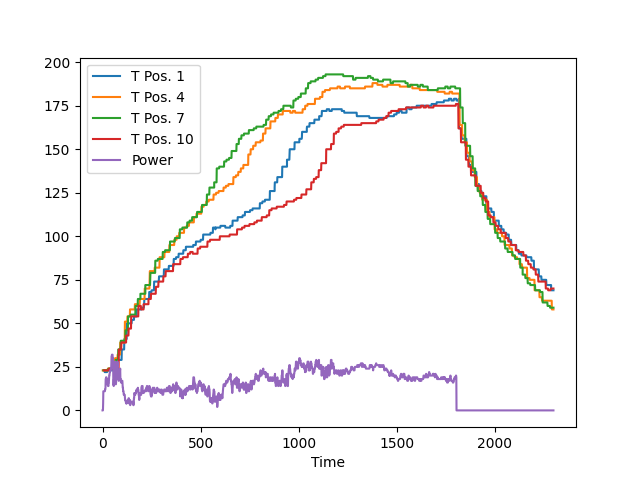

In [4]:
#! file -bi user/85000797 DSK0761_2.csv
mad_results = MADRun('data/mad/85000797_DSK0761_2.csv')
mad_results.plot()

<Axes: xlabel='Time'>

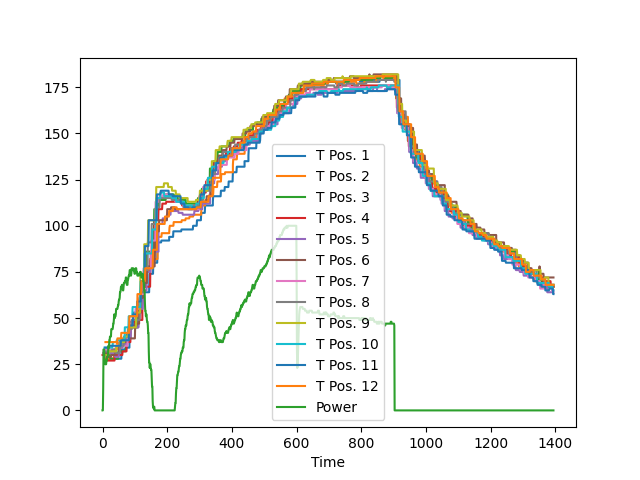

In [5]:
mad_cleaning = MADRun('data/mad/cleaning_run.csv')
mad_cleaning.plot()

## Analyze profile
### Profile for 1 sample

key_points     42
plateaus        2
peaks           3
inflections     5
dtype: int64

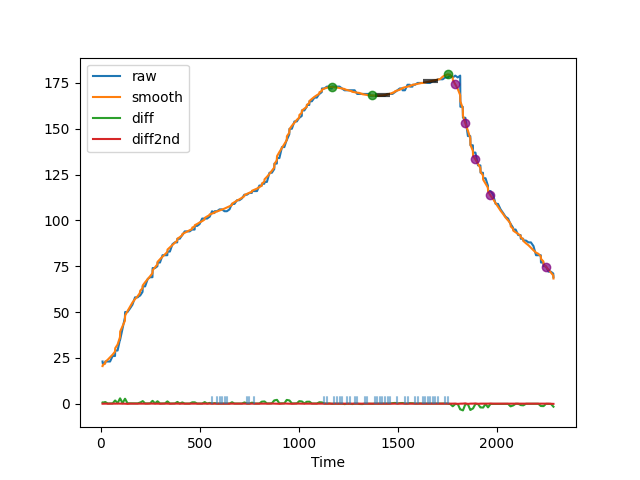

In [7]:
signal_settings = {
    'window_length': 20,
    'plateau_threshold': 0.05,
    'plateau_size': 60,
    'inflection_threshold': 0.05,
    'peak_height': 20
}
sample_profile = mad_results.identify_profile_features('T Pos. 1',signal_settings=signal_settings)
sample_profile.features

### Profiles for all samples

AttributeError: 'MADRun' object has no attribute 'sample_info'

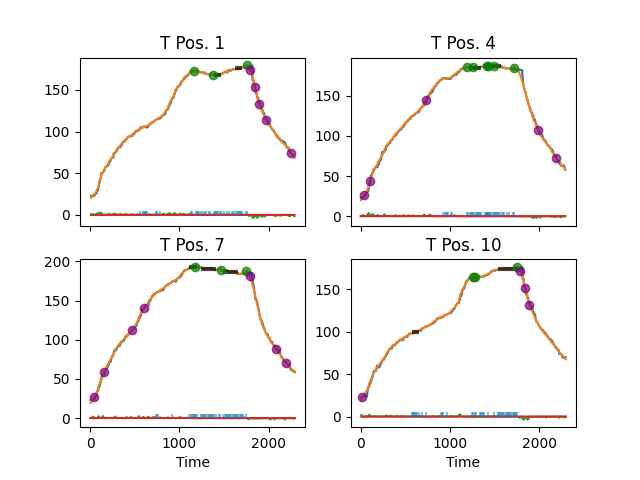

In [8]:
mad_results.profile_feature_analysis(signal_settings=signal_settings,include_sample_)
print(mad_results.features)

## Meta run analysis

In [ ]:
from glob import glob
mad_files = glob('data/mad/*')
mad_files.pop(mad_files.index('data/mad/runs_metadata.csv'))
run_infos = pd.read_csv('data/mad/runs_metadata.csv', header=[0,1], index_col=0)#, decimal=',')
mad_runs = [MADRun(f, runs_info=runs_info) for f in mad_files]
mad_runs=list(filter(lambda x: x.sample_info is not None, mad_runs))
meta_analysis = pd.concat([
    mad_results.profile_feature_analysis(
        signal_settings=signal_settings,
        include_sample_metadata=['Water'],
        include_metadata=['Run Name']
    ) for mad_results in mad_runs
]).reset_index()

In [ ]:
meta_analysis.plot.scatter(x='Weight',y='key_points')